In [1]:
import utils as local_utils
import torch
import torch.nn as nn
#import pytorch_utils
import torch.optim as optim
import torch.optim as optim
import torch.utils.data as DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import sys
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from importlib import reload
import torch.nn.functional as F
from torchvision import transforms, utils, models
import os, sys
from random import shuffle

%matplotlib inline

In [2]:
USE_GPU = True
IMG_SZ = 224

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


## Custom dataset

In [3]:
class LandmarksDataset(DataLoader.Dataset):

    def __init__(self, src_folder, transform=None):
        """
        Args:
            src_folder (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.filenames = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f)) 
                          and f != '.DS_Store']
        self.src_folder = src_folder
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.src_folder, self.filenames[idx])
        
        x = Image.open(img_name)

        if self.transform:
            x = self.transform(x)

        imgf = self.filenames[idx]
        y = int(imgf[imgf.index('_') + 1 : imgf.index('.')]) # filename format: [id_label.jpg]
        sample = (x, y)
        return sample

In [4]:
def get_loader(directory, batch_size):
    '''
    takes in directory for train and val data, and returns loaders for both
    applies normalization:
      1. convert values to range 0-1
      2. set mean, std to those specified in pytorch pretrained models (https://pytorch.org/docs/master/torchvision/models.html)
    
    usage:
        loader_train = get_loader(train_directory, batch_sz)
        loader_val = get_loader(val_directory, batch_sz)
    '''
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

    preprocess = transforms.Compose([
       transforms.ToTensor(),  # converts to range 0-1
       normalize               # sets mean, std
    ])
    
    dset = LandmarksDataset(directory, transform=preprocess)
    loader = DataLoader.DataLoader(dataset=dset, batch_size=batch_size)
    
    print ('dataset size', len(dset))
    return loader

## Training and accuracy checking

In [5]:
def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [6]:
def train(model, optimizer, loader_train, epochs=1, stop=1):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    iters = []
    losses = []
    for e in range(epochs):
        print ('epoch', e)
        
        num_iters = len(loader_train)
        want_print = 10
        print_every = 50
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
        
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print(' Iteration %d out of %d, loss = %.4f' % (t, num_iters, loss.item()))
                iters.append(t)
                losses.append(loss.item())
            
            # break early if we only want to use a part of the dataset (for hyperparameter tuning)
            if t > stop * num_iters:
                break

    return iters, losses

## Plotting

In [7]:
def plot_loss_data(plotting_data, title_str):
    '''
    Plots all loss curves for hyperparameter tuning runs.
    Plots loss vs. iterations.
    '''
    for plot_data in plotting_data:
        iters, losses, label = plot_data        
        plt.plot(iters, losses, label=label)
    plt.title(title_str)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(loc=(1.1, 0.25))
    
    # set figsize
    plt.rcParams["figure.figsize"] = (9, 6)
    
    plt.plot()

In [8]:
def plot_loss_data_v2(plotting_data, title_str):
    '''
    Plots all loss curves for hyperparameter tuning runs
    This version plots loss vs. percent of iterations complete. This means
    each run has the same x distance on the graph.
    '''
    max_n = max([len(iters) for iters, _, _ in plotting_data])
    
    for plot_data in plotting_data:
        iters, losses, label = plot_data 
        n = len(losses)
        
        # need to go between 0 and max_n, with n entries
        dist = (max_n - 1) / (n-1)
        x = [e * dist for e in range(n)]
        x_max = max(x)
        x = [e / x_max for e in x] # normalize to 0 - 1
                
        plt.plot(x, losses, label=label)
        
    plt.title(title_str)
    plt.xlabel('Fraction of tuning run elapsed')
    plt.ylabel('Loss')
    plt.legend(loc=(1.1, 0.25))
    
    plt.rcParams["figure.figsize"] = (9, 6) # set figsize
    plt.plot()

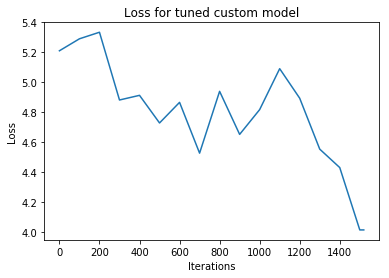

In [11]:

iters = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1520]
losses = [5.2103 , 5.2902, 5.3339 , 4.8820 , 4.9131 , 4.7288, 4.8663 , 4.5275, 4.9398, 4.6526, 4.8179, 5.0909, 4.8937, 4.5543,4.4313,4.0155, 4.01549768447876    ]
plot_single_loss(iters, losses, "Loss for tuned custom model")
def plot_single_loss(iters, losses, title_str):
    plt.plot(iters, losses)
    plt.title(title_str)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    
    # set figsize
    plt.rcParams["figure.figsize"] = (9, 6)
    
    plt.plot()

# Models!

### Resnet

In [10]:
# referenced https://www.kaggle.com/gntoni/using-pytorch-resnet

# hyperparam tuning on lr and batch sz
lr_vals = [0.0001, 0.001, 0.01]
# batch_sizes = [10, 20, 50, 80]
batch_sizes = [80]

train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/val'

momentum = 0.9
num_classes = 200

best_lr = None
best_batch_size = None
best_model = None
best_loss = float('inf')
plotting_data = []

for batch_size in batch_sizes:
    loader_train = get_loader(train_directory, batch_size)
    for lr in lr_vals:
        # set up resnet model with custom FC layer to predict our number of classes
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        num_epochs = 1
        iters, losses = train(model, optimizer, loader_train, num_epochs, 0.20) # stopping early to save time
        
        s = 'lr: %f, batch sz: %d' % (lr, batch_size)
        plotting_data.append((iters, losses, s))
        
        final_loss = losses[-1]
        print('got a loss of ', final_loss, ' for parameters ', 'batch size: ', batch_size, ' lr: ', lr)
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_lr = lr
            best_batch_size = batch_size
            
print("best values ", best_loss, best_lr, best_batch_size)

dataset size 30395
epoch 0


KeyboardInterrupt: 

Check accuracies

In [ ]:
# use best_lr, best_batch_size
lr = best_lr
batch_size = best_batch_size

# load data
loader_val = get_loader(val_directory, batch_size)
loader_train = get_loader(train_directory, batch_size)

# set up squeezenet model with custom final conv layer to predict our number of classes
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# run for full epoch
num_epochs = 1
iters, losses = train(model, optimizer, loader_train, num_epochs)

# get final accuracies
print ('validation accuracy is ', check_accuracy(loader_val, model))
print ('training accuracy is ', check_accuracy(loader_train, model))

# plot loss for fully trained best model
plot_single_loss(iters, losses, 'Loss for tuned Resnet18 model')

Plot loss curves

In [ ]:
plot_data(plotting_data, title_str="Hyperparameter tuning for Resnet18")

In [ ]:
plot_loss_data_v2(plotting_data, title_str="Hyperparameter tuning for Resnet18")

### DL NET!

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)
    
class InceptionModule(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 32, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 32, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 32, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, out_channels-3*32, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
#         print("Finished an inception block")
        return torch.cat(outputs, 1)    
    
class DLNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, filter_size=3, padding=1, pool_size=2):
        super(DLNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, filter_size, padding=padding)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, filter_size, padding=padding)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(pool_size)
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        
        out = self.bn2(out)
        out += residual
        
        out = self.relu2(out)
        out = self.pool(out)
        
#         print("Finished a DL block")
        return out


num_hidden = 400
momentum = 0.9
num_classes = 200

# hyperparam tuning on lr and batch sz
lr_vals = [0.0001, 0.001, 0.01]
batch_sizes = [10, 20, 50, 80]

train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/val'

best_lr = None
best_batch_size = None
best_model = None
best_loss = float('inf')
plotting_data = []

for batch_size in batch_sizes:
    loader_train = get_loader(train_directory, batch_size)
    for lr in lr_vals:
        model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            DLNetBlock(64, 64),
            nn.Dropout(),
            InceptionModule(64, 128),
            nn.Dropout(),
            DLNetBlock(128, 128),
            nn.Dropout(),
            InceptionModule(128, 256),
            nn.Dropout(),
            DLNetBlock(256, 256),

            # added these layers here so that the following linear layer does not have too many parameters and crash
            nn.Conv2d(256, 3, 3, padding=1),
            nn.MaxPool2d(2),

            Flatten(),
            nn.Linear(3 * 14 * 14, num_hidden),
            nn.Linear(num_hidden, num_classes),
        )
        
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        
        num_epochs = 1
        iters, losses = train(model, optimizer, loader_train, num_epochs, 0.20) # stopping early to save time
        
        s = 'lr: %f, batch sz: %d' % (lr, batch_size)
        plotting_data.append((iters, losses, s))
        
        final_loss = losses[-1]
        print('got a loss of ', final_loss, ' for parameters ', 'batch size: ', batch_size, ' lr: ', lr)
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_lr = lr
            best_batch_size = batch_size
            
print("best values ", best_loss, best_lr, best_batch_size)
# get final accuracies
print ('validation accuracy is ', check_accuracy(loader_val, best_model))
print ('training accuracy is ', check_accuracy(loader_train, best_model))

# plot loss for fully trained best model
plot_single_loss(iters, losses, 'Loss for tuned custom model')
plot_loss_data_v2(plotting_data, title_str="Hyperparameter tuning for Custom Net")

dataset size 30395
epoch 0
Finished a DL block
Finished an inception block
Finished a DL block
Finished an inception block
Finished a DL block
 Iteration 0 out of 3040, loss = 5.2462
Finished a DL block
Finished an inception block
Finished a DL block
Finished an inception block
Finished a DL block
Finished a DL block
Finished an inception block
Finished a DL block
Finished an inception block
Finished a DL block
Finished a DL block
Finished an inception block
Finished a DL block
Finished an inception block
Finished a DL block
Finished a DL block
Finished an inception block
Finished a DL block
Finished an inception block
Finished a DL block
Finished a DL block
Finished an inception block
Finished a DL block
Finished an inception block
Finished a DL block
 Iteration 5 out of 3040, loss = 5.2405
Finished a DL block
Finished an inception block
Finished a DL block
Finished an inception block
Finished a DL block
Finished a DL block
Finished an inception block
Finished a DL block
Finished an i

### Squeezenet

In [ ]:
# hyperparam tuning on lr and batch sz
lr_vals = [0.0001, 0.001, 0.01]
batch_sizes = [10, 20, 50, 80]

train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/val'

# for testing
# train_directory = '../data/data_200c/mini'
# val_directory = '../data/data_200c/mini'
# batch_sizes = [1, 2, 5, 8]

momentum = 0.9
num_classes = 200

best_lr = None
best_batch_size = None
best_model = None
best_loss = float('inf')
plotting_data = []

for batch_size in batch_sizes:
    loader_train = get_loader(train_directory, batch_size)
    for lr in lr_vals:
        # set up squeezenet model with custom final conv layer to predict our number of classes
        model = models.squeezenet1_0(pretrained=True)
        final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        model.classifier = nn.Sequential(
                    nn.Dropout(p=0.5),
                    final_conv,
                    nn.ReLU(inplace=True),
                    nn.AvgPool2d(13))
        
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        num_epochs = 1
        iters, losses = train(model, optimizer, loader_train, num_epochs, 0.20) # stopping early to save time
        
        s = 'lr: %f, batch sz: %d' % (lr, batch_size)
        plotting_data.append((iters, losses, s))
        
        final_loss = losses[-1]
        print('got a loss of ', final_loss, ' for parameters ', 'batch size: ', batch_size, ' lr: ', lr)
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_lr = lr
            best_batch_size = batch_size
print (' ')          
print("best loss: ", best_loss, 'best lr', best_lr, 'best batch sz', best_batch_size)

Plot loss curves for hyperparam tuning

In [ ]:
plot_loss_data(plotting_data, title_str="Hyperparameter tuning for Squeezenet")

In [ ]:
plot_loss_data_v2(plotting_data, title_str="Hyperparameter tuning for Squeezenet")

Train best model for full epoch, get final val & train accuracy, plot loss curve

In [ ]:
# use best_lr, best_batch_size
lr = best_lr
batch_size = best_batch_size

# load data
loader_val = get_loader(val_directory, batch_size)
loader_train = get_loader(train_directory, batch_size)

# set up squeezenet model with custom final conv layer to predict our number of classes
model = models.squeezenet1_0(pretrained=True)
final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
model.num_classes = num_classes
model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AvgPool2d(13))

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# run for full epoch
num_epochs = 1
iters, losses = train(model, optimizer, loader_train, num_epochs)

In [ ]:
# get final accuracies
print ('validation accuracy is ', check_accuracy(loader_val, model))
print ('training accuracy is ', check_accuracy(loader_train, model))

# plot loss for fully trained best model
plot_single_loss(iters, losses, 'Loss for tuned Squeezenet model')

In [ ]:
# plot loss for fully trained best model
plot_single_loss(iters, losses, 'Loss for tuned Squeezenet model')

### Inception

In [ ]:
# hyperparam tuning on lr and batch sz
lr_vals = [0.0001, 0.001, 0.01]
batch_sizes = [10, 20, 50, 80]

train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/val'

# for testing
# train_directory = '../data/data_200c/mini'
# val_directory = '../data/data_200c/mini'
# batch_sizes = [1, 2, 5, 8]

momentum = 0.9
num_classes = 200

best_lr = None
best_batch_size = None
best_model = None
best_loss = float('inf')
plotting_data = []

for batch_size in batch_sizes:
    loader_train = get_loader(train_directory, batch_size)
    for lr in lr_vals:
        # set up inception model with custom final FC layer to predict our number of classes
        model = models.inception_v3(pretrained=True)
        model.aux_logit=False
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        num_epochs = 1
        iters, losses = train(model, optimizer, loader_train, num_epochs, 0.20) # stopping early to save time
        
        s = 'lr: %f, batch sz: %d' % (lr, batch_size)
        plotting_data.append((iters, losses, s))
        
        final_loss = losses[-1]
        print('got a loss of ', final_loss, ' for parameters ', 'batch size: ', batch_size, ' lr: ', lr)
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_lr = lr
            best_batch_size = batch_size
print (' ')          
print("best loss: ", best_loss, 'best lr', best_lr, 'best batch sz', best_batch_size)

Plot loss curves for hyperparam tuning

In [ ]:
plot_loss_data(plotting_data, title_str="Hyperparameter tuning for Inception")

In [ ]:
plot_loss_data_v2(plotting_data, title_str="Hyperparameter tuning for Inception")

Train best model for full epoch, get final val & train accuracy, plot loss curve

In [ ]:
# use best_lr, best_batch_size
lr = best_lr
batch_size = best_batch_size

# load data
loader_val = get_loader(val_directory, batch_size)
loader_train = get_loader(train_directory, batch_size)

# set up inception model with custom final FC layer to predict our number of classes
model = models.inception_v3(pretrained=True)
model.aux_logit=False
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# run for full epoch
num_epochs = 1
iters, losses = train(model, optimizer, loader_train, num_epochs)

In [ ]:
# get final accuracies
print ('validation accuracy is ', check_accuracy(loader_val, model))
print ('training accuracy is ', check_accuracy(loader_train, model))

In [ ]:
# plot loss for fully trained best model
plot_single_loss(iters, losses, 'Loss for tuned Inception model')